# 4) 2nd model training

In this notebook, we will try to determine if the poor performance from our previous training was due to the model (and/or its training) or the limited training examples.  

This time, a resnet34 will be trained from scratch (bott r

In [2]:
%%capture
!pip install smdebug
!pip install torchvision --no-cache-dir  

In [3]:
import json
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

import boto3
import os
import numpy as np

from PIL import Image
import IPython

session = sagemaker.Session()

bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

prefix = "capstone-inventory-project"

[2022-01-17 09:50:30.340 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
Default Bucket: sagemaker-us-east-1-646714458109
AWS Region: us-east-1
RoleArn: arn:aws:iam::646714458109:role/service-role/AmazonSageMaker-ExecutionRole-20211122T183493


In [4]:
# Set up debugging and profiling rules and hooks
rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params=FrameworkProfile(num_steps=1))

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "10"})

https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel-use-api.html

Batch Size
In distributed training, as more nodes are added, batch sizes should increase proportionally. To improve convergence speed as you add more nodes to your training job and increase the global batch size, increase the learning rate.

One way to achieve this is by using a gradual learning rate warmup where the learning rate is ramped up from a small to a large value as the training job progresses. This ramp avoids a sudden increase of the learning rate, allowing healthy convergence at the start of training. For example, you can use a Linear Scaling Rule where each time the mini-batch size is multiplied by k, the learning rate is also multiplied by k. To learn more about this technique, see the research paper, Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour, Sections 2 and 3.  

Therefore I will double our current parameters. 

In [9]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="scripts/train_resnet34.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",        
    profiler_config=profiler_config,      # profiler hook
    debugger_hook_config=debugger_config, # debugger hook
    output_path = 's3://{}/{}/main_training'.format(bucket, prefix),  # The training jobs output (mainly model artefacts) will go there.
    hyperparameters={                                                 # Best values from the previous hpo
        "batch-size": 16,
        "lr": 0.002}
)

estimator.fit({"train": "s3://{}/{}/data".format(bucket, prefix)})

2022-01-17 10:08:11 Starting - Starting the training job...
2022-01-17 10:08:34 Starting - Launching requested ML instancesProfilerReport-1642414090: InProgress
......
2022-01-17 10:09:34 Starting - Preparing the instances for training.........
2022-01-17 10:11:04 Downloading - Downloading input data............
2022-01-17 10:13:08 Training - Downloading the training image......
2022-01-17 10:14:13 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-17 10:14:14,587 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-17 10:14:14,607 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-17 10:14:16,050 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-17 10:14:16,538 sagemaker-training-toolkit INFO     Invoking user script
Training

In [10]:
print(estimator.latest_job_debugger_artifacts_path())

s3://sagemaker-us-east-1-646714458109/capstone-inventory-project/main_training/pytorch-training-2022-01-17-10-08-10-837/debug-output


In [11]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())

[2022-01-17 10:37:19.367 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-646714458109/capstone-inventory-project/main_training/pytorch-training-2022-01-17-10-08-10-837/debug-output
[2022-01-17 10:37:19.841 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 235 more expected)', IncompleteRead(0 bytes read, 235 more expected)) while reading s3://sagemaker-us-east-1-646714458109/capstone-inventory-project/main_training/pytorch-training-2022-01-17-10-08-10-837/debug-output/index/000000000/000000000380_worker_0.json . Will retry now
[2022-01-17 10:37:30.486 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-17 10:37:31.509 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO trial.

In [12]:
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

46
549


In [13]:
# Set up functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


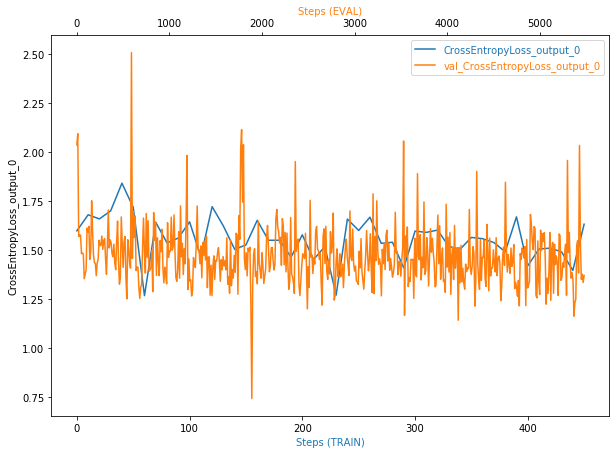

In [14]:
plot_tensor(trial, "CrossEntropyLoss_output_0")